In [1]:
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch

# imports to load some data
from fours.utils.data_handling import load_adi_data

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.photometry import flux_ratio2mag, mag2flux_ratio

from pynpoint.util.analysis import fake_planet

# Load the data

In [2]:
dataset_file = Path("/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/09_new_rotation_loss/x2_different_residual_creations/")
exp_id = str("0123a")
use_rotation_loss = True
lambda_reg = float(850)

In [3]:
science_data, angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=str(dataset_file),
        data_tag="object_stacked_05",
        psf_template_tag="psf_template",
        para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

# other parameters
dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale = 0.02718

# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

In [4]:
dataset_id = "0115b"

# add the fake planet
fake_planet_config_file = "/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_" + exp_id + ".json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [5]:
fake_planet_config["flux_ratio"] = mag2flux_ratio(12.)
fake_planet_config["separation"] = 30
fake_planet_config["planet_position"] = [0., 0., 30, 80.]

In [6]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template,
    parang=angles - np.pi/2, # the pi/2 is to correct the parang to the north
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [7]:
science_data_torch_with_planet = torch.from_numpy(data_with_fake_planet).float()

# Import the noise models

In [8]:
from fours.position_flux.pca import PCANoiseModel
from fours.position_flux.negfc import NegFC
from fours.models.psf_subtraction import FourS

from tqdm import tqdm
from torch import optim

# run a test with PCA

In [9]:
pca_model = PCANoiseModel(
    angles=angles,
    image_shape=science_data.shape[1],
    pca_number=300,
    approx_svd=5000)

In [10]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"] + 2,
    init_pos_angle=fake_planet_config["planet_position"][-1] - 4,
    init_magnitude=11.5,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",)

In [11]:
# move everything to the GPU
science_data_torch_with_planet = science_data_torch_with_planet.to(0)
negfc = negfc.to(0)
pca_model = pca_model.to(0)

In [12]:
input_data = science_data_torch_with_planet

# create the optimizer
optimizer_kwargs = {
    "max_iter": 20,
    "history_size": 10}

optimizer = optim.LBFGS(
    negfc.parameters(),
    **optimizer_kwargs)

In [13]:
for j in range(20):
    print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())
    after_negfc = negfc(science_data_torch_with_planet)
    pca_model.update_noise_model(after_negfc)

    # iterate for 100 steps
    for i in range(20):
        def closure():        
            optimizer.zero_grad()
            after_negfc = negfc(science_data_torch_with_planet)
            
            #pca_model.update_noise_model(after_negfc)
            after_pca_neg_fc = pca_model(after_negfc)
            loss = torch.sum(after_pca_neg_fc**2)
            loss.backward()
            
            return loss

        optimizer.step(closure)

32.0 76.0 11.5
31.774494171142578 76.8847427368164 12.087950706481934
31.18558692932129 78.20600128173828 12.492368698120117
31.18558692932129 78.20600128173828 12.492368698120117
30.54210662841797 79.17823791503906 12.560996055603027
30.154605865478516 79.59913635253906 12.487272262573242
29.95743751525879 79.76332092285156 12.415915489196777
29.850990295410156 79.82984161376953 12.36722183227539
29.850984573364258 79.82984161376953 12.367225646972656
29.790964126586914 79.85637664794922 12.335657119750977
29.756181716918945 79.86685180664062 12.315750122070312
29.735742568969727 79.8707046508789 12.303496360778809
29.723459243774414 79.87174987792969 12.295546531677246
29.716073989868164 79.87174224853516 12.290711402893066
29.71162986755371 79.87145233154297 12.287809371948242
29.708938598632812 79.87129974365234 12.285933494567871
29.707292556762695 79.87104797363281 12.284758567810059
29.706289291381836 79.8708724975586 12.284015655517578
29.706287384033203 79.87085723876953 12.28

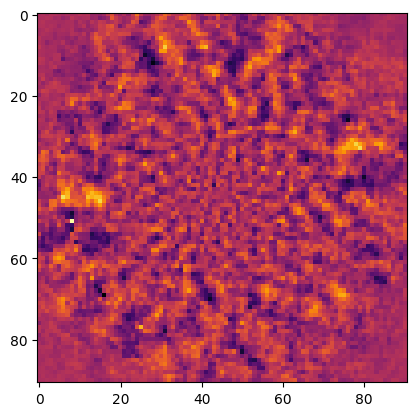

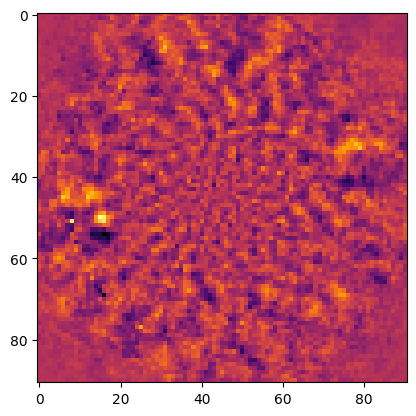

In [18]:
after_negfc = negfc(science_data_torch_with_planet)
after_pca_neg_fc = pca_model(after_negfc)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")
plt.show()

pca_model.update_noise_model(science_data_torch_with_planet)
after_pca_neg_fc = pca_model(science_data_torch_with_planet)
plt.imshow(after_pca_neg_fc.cpu().detach().numpy(), cmap="inferno")

# Run the same for the FourS model

In [19]:
experiment_root_dir = Path("/fast/mbonse/s4/70_results/new_implementation_test/02_negfc")
experiment_root_dir.mkdir(exist_ok=True)

In [20]:
fours_model = FourS(
    science_cube=data_with_fake_planet,
    adi_angles=angles,
    psf_template=psf_template,
    noise_model_lambda=100,
    normalization_type="dynamic",
    psf_fwhm=3.6,
    right_reason_mask_factor=1.5,
    rotation_grid_subsample=1,
    device=0,
    work_dir=experiment_root_dir,
    verbose=True)

In [21]:
fours_model.fit_noise_model(
        num_epochs=100,
        training_name="First_training",
        logging_interval=10)

S4 model: Fit noise model ... 

  0%|          | 0/100 [00:00<?, ?it/s]

[DONE]


In [22]:
# create the NegFC model
negfc = NegFC(
    psf_template=psf_template,
    all_angles=angles,
    input_size=science_data.shape[1],
    init_separation=fake_planet_config["separation"] + 2,
    init_pos_angle=fake_planet_config["planet_position"][-1] - 2,
    init_magnitude=11.5,
    dit_science=dit_science,
    dit_psf_template=dit_psf_template,
    nd_factor=1.0,
    interpolation="bicubic",)

In [23]:
negfc = negfc.to(0)
science_data_torch_with_planet = science_data_torch_with_planet.to(0)

# create the optimizer
optimizer_kwargs = {
    "max_iter": 20,
    "history_size": 10}

optimizer = optim.LBFGS(
    negfc.parameters(),
    **optimizer_kwargs)

In [24]:
print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())

for j in range(20):    
    # move everything to the GPU
    fours_model.noise_model = fours_model.noise_model.to(0)
    fours_model.rotation_model = fours_model.rotation_model.to(0)
    fours_model.normalization_model = fours_model.normalization_model.to(0)
    fours_model.noise_model.betas_raw.requires_grad = False
    fours_model.noise_model.intercept.requires_grad = False
    fours_model.noise_model.compute_betas()

    # iterate for 200 steps
    for i in tqdm(range(200)):
        def closure():        
            optimizer.zero_grad()
            after_negfc = negfc(science_data_torch_with_planet)
            after_pca_neg_fc = fours_model.forward(after_negfc)
            loss = torch.sum(after_pca_neg_fc**2)
            loss.backward()

            return loss

        optimizer.step(closure)
        
    fours_model.noise_model.betas_raw.requires_grad = True
    fours_model.noise_model.intercept.requires_grad = True
    print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())
    after_negfc = negfc(science_data_torch_with_planet)    
    
    fours_model.update_noise_model(
        images=after_negfc.detach(),
        num_epochs=50,
        training_name="update_" + str(j+1),
        logging_interval=10)

32.0 78.0 11.5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.54it/s]

29.672779083251953 79.96238708496094 12.23140811920166
S4 model: Fit noise model ... 

  0%|          | 0/50 [00:00<?, ?it/s]

[DONE]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.09it/s]

29.62006950378418 80.06543731689453 12.165699005126953
S4 model: Fit noise model ... 

  0%|          | 0/50 [00:00<?, ?it/s]

[DONE]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.71it/s]

29.65021514892578 80.02201080322266 12.124567985534668
S4 model: Fit noise model ... 

  0%|          | 0/50 [00:00<?, ?it/s]

[DONE]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:24<00:00,  8.09it/s]

29.658292770385742 80.09593963623047 12.167905807495117
S4 model: Fit noise model ... 

  0%|          | 0/50 [00:00<?, ?it/s]

[DONE]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:07<00:00,  2.97it/s]

29.65799903869629 80.08731842041016 12.162522315979004
S4 model: Fit noise model ... 

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(negfc.separation.item(), negfc.pos_angle.item(), negfc.magnitude.item())